## Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sn
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Dataset

In [2]:
# load dataset
# dataset is too large to load to github. We're maintaining local copies
data_path = os.path.join('data', 'raw')
matches = pd.read_csv(os.path.join(data_path, 'matchups.csv'))
matches.head()

,P_MATCH_ID,GOLDEARNED,TOTALMINIONSKILLED,WIN,KILLS,ASSISTS,DEATHS,CHAMPION,VISIONSCORE,PUUID,TOTALDAMAGEDEALTTOCHAMPIONS,SUMMONERNAME,GAMEVERSION,Unnamed: 13
0,TR1_1201957752_top,14425,194,False,14,5,7,Kassadin,17,phduyQLB8gBjUerFwiVOtyLLHE9jxw7Jq7dwab_CtRddAv...,33426,Borke,11.14.384.6677,NaN
1,TR1_1201957752_top,12920,177,True,3,13,6,Fiora,17,SgQ5hm74vmXVDB3GIt3ka7gaBXFpNnT3PbHU8TbjEk5PJ8...,12092,Nora Durst,11.14.384.6677,NaN
2,TR1_1201957752_middle,13483,221,False,7,3,6,Yone,20,m7Sxq9HxRKLIgf0n0QOKhfHq8jNMZ-k1VhW_jcb307sUya...,20604,Fightêr Yone,11.14.384.6677,NaN
3,TR1_1201957752_middle,11375,167,True,4,15,7,Corki,27,pa-g2VGIEJn7CJCYYQU1PaHUqjS9pB7M4PsDcjM3ac5ysM...,30150,AM SORİİ HE,11.14.384.6677,NaN
4,TR1_1201957752_bottom,11320,197,False,5,10,12,Kaisa,17,_WeC06P4yIMW7ZMWi6bmwCagXp7c7bxxGv6nNW4--SGqXp...,16689,º J İ N X º,11.14.384.6677,NaN


In [3]:
print(matches.shape)

(1312252, 14)


## Data Description

Dataset has 1312252 records, and 14 columns initially

Match attributes - attributes common to every match

 - GOLDEARNED - Gold earned by the player in the match
 - TOTALMINIONSKILLED - Total minions killed by the player in the match
 - WIN - Match won or lost. Either True or False
 - KILLS - Total kills by the player in the match
 - ASSISTS - Total assists by the player in the match
 - DEATHS - Total deaths of the player in the match
 - CHAMPION - The champion the player was playing
 - VISIONSCORE - The vision score of the player in the match
 - TOTALDAMAGEDEALTTOCHAMPIONS - Total damage delt by the player to other players
     
     

Unique attributes - attributes unique to every match or the game itself

 - P_MATCH_ID - Unique identifier for player in a match. Contains 3 important attributes - Region, ID, Role separated by '_'
 - PUUID - The unique identifier of the player. Is tied to the player's RIOT games account, and is unique through game, across all regions.
 - SUMMONERNAME - The "username" / "gamertag" of the player. Is unique within a region.
 - GAMEVERSION - The version of the game a match belongs to.

Irrelevant attributes

 - Unnamed: 13 - will be deleted

## Data Preprocessing

### Unpack P_MATCH_ID into new columns

In [4]:
# splitting the P_MATCH_ID to Region, Match Id and Role
matches[['REGION', 'MATCH_ID', 'ROLE']] = matches['P_MATCH_ID'].str.split('_', expand=True)

# MATCH_ID is not unique across regions. Create a unique identifier.
matches['MATCH_ID'] = matches['MATCH_ID'].str.cat(matches[['REGION']], sep='_')

### Drop unnecessary columns

In [5]:
# Dropping unnecessary columns
matches = matches.drop(columns = ['P_MATCH_ID', 'Unnamed: 13'])

In [6]:
#printing column names 
print(matches.columns)

Index(['GOLDEARNED', 'TOTALMINIONSKILLED', 'WIN', 'KILLS', 'ASSISTS', 'DEATHS',
       'CHAMPION', 'VISIONSCORE', 'PUUID', 'TOTALDAMAGEDEALTTOCHAMPIONS',
       'SUMMONERNAME', 'GAMEVERSION', 'REGION', 'MATCH_ID', 'ROLE'],
      dtype='object')


### Drop matches with invalid or null values


In [7]:
#Check for null values
matches[matches.isnull().any(axis=1)]

,GOLDEARNED,TOTALMINIONSKILLED,WIN,KILLS,ASSISTS,DEATHS,CHAMPION,VISIONSCORE,PUUID,TOTALDAMAGEDEALTTOCHAMPIONS,SUMMONERNAME,GAMEVERSION,REGION,MATCH_ID,ROLE
398808,6051,37,True,0,10,0,Lulu,32,L2m7Wx4EYFqHCgGzHRz1IWpdjPY17m9epJyZI4_A1IswHo...,3502,NaN,11.15.389.2308,NA1,3993107745_NA1,utility
1241011,17188,239,True,11,14,4,Kassadin,20,ZKqRsvGm94WBAZf8w_16AmPYZ33fHKKh440ARecW7Mf7C7...,34659,NaN,11.3.357.5376,BR1,2186840449_BR1,middle
1303486,9579,11,True,4,18,1,Janna,56,L2m7Wx4EYFqHCgGzHRz1IWpdjPY17m9epJyZI4_A1IswHo...,11009,NaN,11.15.389.2308,NA1,3990915292_NA1,utility


Some records have null values. Drop these

In [8]:
null_index = matches[matches.isnull().any(axis=1)].MATCH_ID.index.tolist()
matches = matches.drop(index = null_index)
# matches = matches[~matches.MATCH_ID.isin(null_match_id)]

In [9]:
matches[matches.isnull().any(axis=1)].count().sum()

0

Check for negative values

In [10]:
numeric_columns = matches._get_numeric_data().columns
matches[matches[numeric_columns].values < 0]

,GOLDEARNED,TOTALMINIONSKILLED,WIN,KILLS,ASSISTS,DEATHS,CHAMPION,VISIONSCORE,PUUID,TOTALDAMAGEDEALTTOCHAMPIONS,SUMMONERNAME,GAMEVERSION,REGION,MATCH_ID,ROLE
124050,15365,22,True,6,11,9,Viego,25,NDFyJQKzbvK2qM4KwLhEDVAmRfRSbOUWKWGuLGEgHvqb-N...,-2147483648,I am Not PogPP,11.5.361.3108,TR1,1149701131_TR1,jungle


Some records have negative values. Drop these

In [11]:
invalid_index = matches[matches[numeric_columns].values < 0].MATCH_ID.index.tolist()
matches = matches.drop(index=invalid_index)
# matches = matches[~matches.MATCH_ID.isin(invalid_match_id)]

In [12]:
matches[matches[numeric_columns].values < 0].count().sum()

0

In [13]:
print(matches.columns)
print(matches.shape)

Index(['GOLDEARNED', 'TOTALMINIONSKILLED', 'WIN', 'KILLS', 'ASSISTS', 'DEATHS',
       'CHAMPION', 'VISIONSCORE', 'PUUID', 'TOTALDAMAGEDEALTTOCHAMPIONS',
       'SUMMONERNAME', 'GAMEVERSION', 'REGION', 'MATCH_ID', 'ROLE'],
      dtype='object')
(1312248, 15)


## Preprocessing Summary
After preprocessing the dataset has 1312248 records and 15 columns.

Two columns were dropped from the dataset

 - P_MATCH_ID 
 - Unnamed: 13

Three columns were added to the dataset

 - REGION - Region (US, EU, etc.) in which the match was played. Only players from a single region can queue together.
 - MATCH_ID - Unique identifier for each match in the dataset. Each match must have 10 records
 - ROLE - The role the player was playing in the match


## Data Analysis

### Correlation Analysis

In [14]:
# Correlation for numerical columns
numeric_columns = matches._get_numeric_data().columns 
matches_num = matches[numeric_columns]

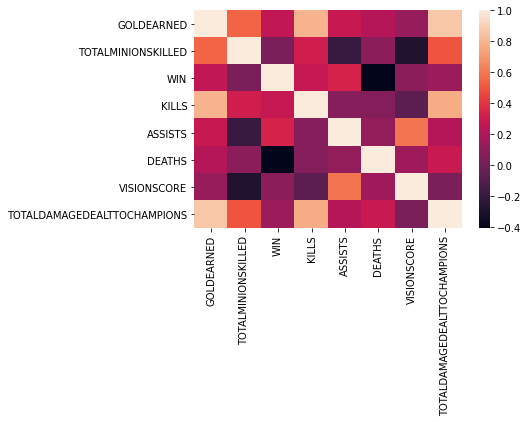

In [15]:
# FInding out the correlation between different features in the matrix 
plt.figure()
corrMatrix = matches_num.corr()
sn.heatmap(corrMatrix)#, annot=True)
plt.show('png')

#### Inference
- It can be observed from the correlation matrix that Kills, Assists and Gold earned have a stronger correlation with Winning than other factors.
   - Interestingly Assists has a higher correlation than kills.
- Deaths have a strong negative correlation, meaning the higher the number of deaths lesser the probability of wining 

### Feature Distributions

<Figure size 432x288 with 0 Axes>

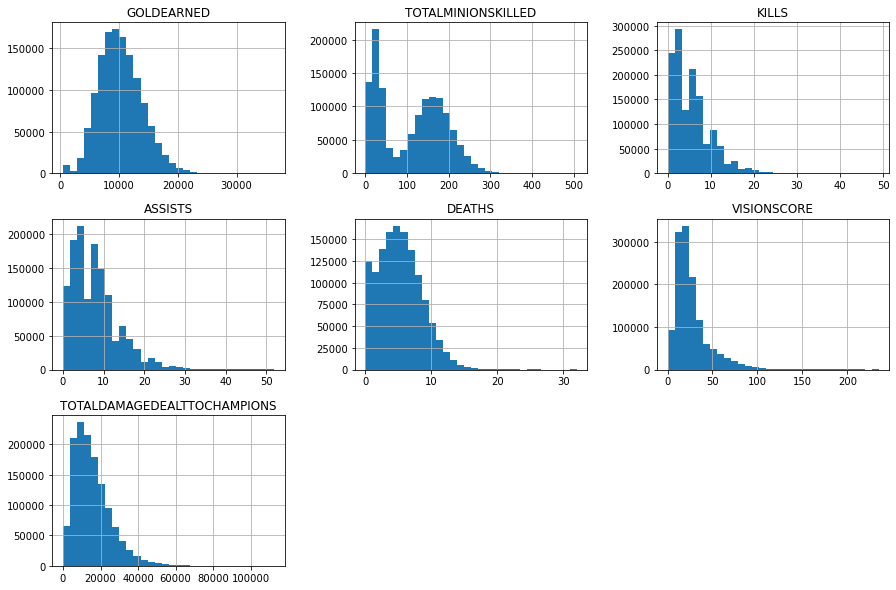

In [16]:
# plotting to understand the distribution of each feature
plt.figure()
matches.hist(bins=30, figsize=(15, 10))
plt.show()

### Feature Distribution of wins and losses

In [17]:
# Grouping by win to find the average values of all wins and losses
df_avg = matches_num.groupby(['WIN'], as_index=False).mean()
df_avg

,WIN,GOLDEARNED,TOTALMINIONSKILLED,KILLS,ASSISTS,DEATHS,VISIONSCORE,TOTALDAMAGEDEALTTOCHAMPIONS
0,False,9334.808251,108.632406,4.184977,5.943879,6.669664,24.678584,14262.776372
1,True,11210.007871,113.778874,6.665630,9.762484,4.197897,27.892373,17049.371893


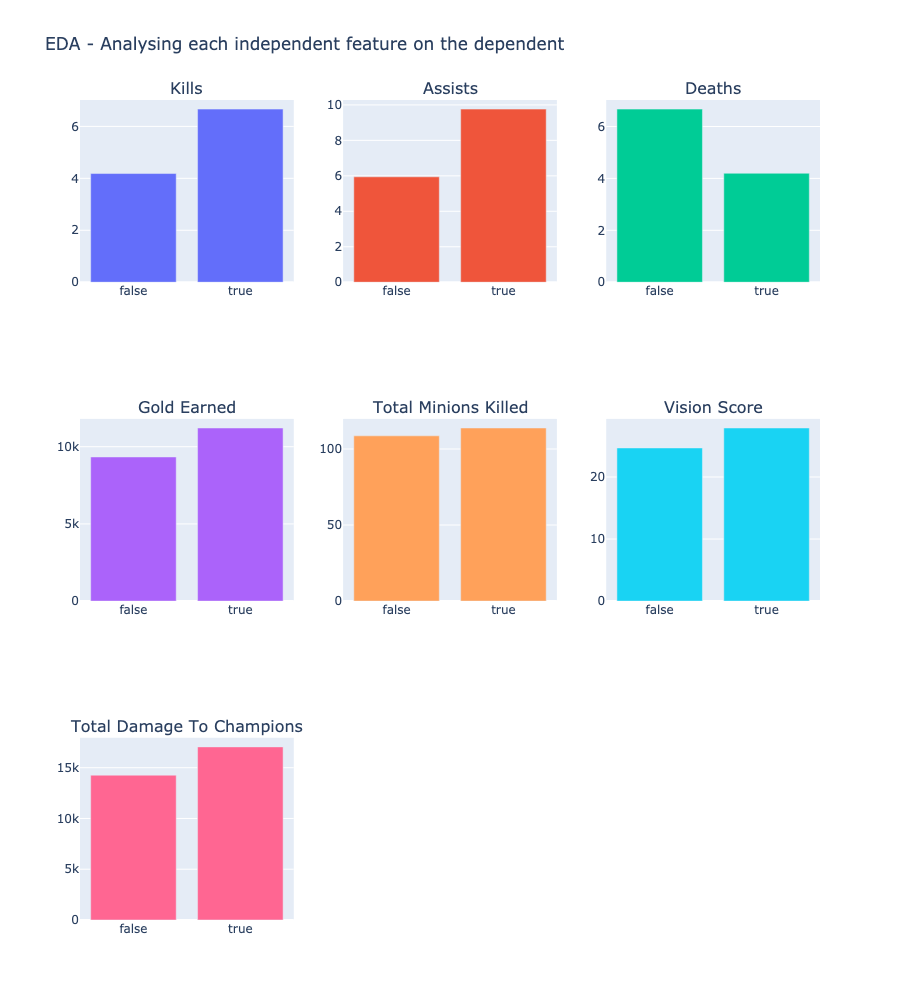

In [18]:
# Using plotly to plot bar graph for each feature and understanding the effect of it on the independent variable
import plotly.graph_objects as go
fig = make_subplots(rows=3, cols=3, subplot_titles=("Kills","Assists", "Deaths","Gold Earned",'Total Minions Killed',
                                                   'Vision Score','Total Damage To Champions'))

fig.add_trace(
    go.Bar( x=df_avg['WIN'], y=df_avg['KILLS']),
    row=1, col=1
)

fig.add_trace(
    go.Bar( x=df_avg['WIN'], y=df_avg['ASSISTS']),
    row=1, col=2
)
fig.add_trace(
    go.Bar( x=df_avg['WIN'], y=df_avg['DEATHS']),
    row=1, col=3
)
fig.add_trace(
    go.Bar( x=df_avg['WIN'], y=df_avg['GOLDEARNED']),
    row=2, col=1
)
fig.add_trace(
    go.Bar( x=df_avg['WIN'], y=df_avg['TOTALMINIONSKILLED']),
    row=2, col=2
)
fig.add_trace(
    go.Bar( x=df_avg['WIN'], y=df_avg['VISIONSCORE']),
    row=2, col=3
)
fig.add_trace(
    go.Bar( x=df_avg['WIN'], y=df_avg['TOTALDAMAGEDEALTTOCHAMPIONS']),
    row=3, col=1
)

fig.update_layout(height=1000, width=900, showlegend=False,title_text="EDA - Analysing each independent feature on the dependent")
fig.show("png")



#### Inference

- It can be observed that the average number of kills and assists is higher for winning players.
- Average deaths are higher for the losing players, indicating that losing teams die more.
- Total minions killed is nearly the same for both the winning and losing teams with the winning team having slightly higher minion kills.
- Winning players have more gold earned and have dealt more damage to champions.
- It can be inferred from the bar graphs that Kills, Assists, Deaths, Gold Earned, Total Damage to Champions is vital in deciding who wins or losses 

### Feature Averages by region

In [19]:
# Groupying by region to better understand the traits 
df_avg_region = matches.groupby(['WIN','REGION'], as_index=False).mean()
df_avg_region

,WIN,REGION,GOLDEARNED,TOTALMINIONSKILLED,KILLS,ASSISTS,DEATHS,VISIONSCORE,TOTALDAMAGEDEALTTOCHAMPIONS
0,False,BR1,9569.703907,108.866762,4.477288,6.230531,6.951157,24.981590,14850.509069
1,False,EUN1,9601.643202,108.933287,4.439343,6.165974,6.971851,23.870431,15056.121653
2,False,EUW1,9442.107856,112.220425,4.125964,5.882812,6.640704,25.349837,14386.359962
3,False,JP1,9093.217773,110.429991,3.760889,5.583163,6.312189,25.308097,13354.591640
4,False,KR,8560.849123,103.471931,3.633102,5.336727,6.063472,23.708676,12596.096660
5,False,LA1,9400.650426,109.837606,4.008143,5.945713,6.415732,26.514051,14290.637897
6,False,LA2,9357.916197,109.098822,4.087814,5.926267,6.526114,26.244496,14261.474484
7,False,NA1,9108.243044,108.688039,3.854923,5.663113,6.323395,24.625426,13484.531738
8,False,RU,9736.653012,109.893976,4.515663,6.378313,7.130120,24.253012,15138.204819
9,False,TR1,9565.851087,105.754676,4.703310,6.359390,7.316473,22.437212,15130.501573


#### Inference
- It can be observed that most the features have the same average across different regions


### Experimental Analysis
This section might be useful in the future

In [20]:
# Creating player rating 
# Based on the data available, we are giving rating to each player based on the number of wins

extract = matches[matches['WIN']==True][['PUUID','WIN']]
count = extract.groupby(['PUUID'],as_index=False).count()
# Beginer -> 0 to 10 wins 
# Intermediate -> 10 to 50 wins 
# Advanced -> 50 to 500 wins 
count['Rating']=pd.cut(count['WIN'], bins=[0,10,50,500], labels=['Beginer','Intermediate','Advanced'])

In [21]:
# Merging the player rating it back to the orginal data
matches_merged=matches.copy()
matches_merged=matches_merged.merge(count[['Rating','PUUID']],on='PUUID',how='left')
# first time players will have NaN after merging, so they will be denoted as Beginer 
matches_merged['Rating']=matches_merged['Rating'].fillna('Beginer') 

In [22]:
#Finding the win percentage for each player rating  
matches_merged.groupby(['Rating','WIN'],as_index=False).count() # finding the number of wins 

,Rating,WIN,GOLDEARNED,TOTALMINIONSKILLED,KILLS,ASSISTS,DEATHS,CHAMPION,VISIONSCORE,PUUID,TOTALDAMAGEDEALTTOCHAMPIONS,SUMMONERNAME,GAMEVERSION,REGION,MATCH_ID,ROLE
0,Beginer,False,447175,447175,447175,447175,447175,447175,447175,447175,447175,447175,447175,447175,447175,447175
1,Beginer,True,410179,410179,410179,410179,410179,410179,410179,410179,410179,410179,410179,410179,410179,410179
2,Intermediate,False,187290,187290,187290,187290,187290,187290,187290,187290,187290,187290,187290,187290,187290,187290
3,Intermediate,True,219199,219199,219199,219199,219199,219199,219199,219199,219199,219199,219199,219199,219199,219199
4,Advanced,False,21710,21710,21710,21710,21710,21710,21710,21710,21710,21710,21710,21710,21710,21710
5,Advanced,True,26695,26695,26695,26695,26695,26695,26695,26695,26695,26695,26695,26695,26695,26695


In [23]:
# Creating the Win Percentage for each player rating 

df_ratio = matches_merged.groupby(['Rating'],as_index=False)['WIN'].count()
df_ratio['win_percentage']=np.nan
Rating = ['Beginer','Intermediate','Advanced']
True_False = {'Beginer':445952, 'Intermediate':190296,'Advanced':19809}
for i in Rating: 
    df_ratio['win_percentage'].loc[(df_ratio.Rating==i)]=(True_False.get(i)/df_ratio[df_ratio.Rating==i]['WIN'])*100
    

In [24]:
# win percentage 
df_ratio

,Rating,WIN,win_percentage
0,Beginer,857354,52.014920
1,Intermediate,406489,46.814551
2,Advanced,48405,40.923458


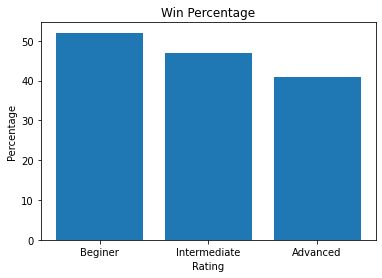

In [25]:
plt.bar(df_ratio['Rating'],df_ratio.win_percentage)
plt.title('Win Percentage')
plt.xlabel('Rating')
plt.ylabel('Percentage')
plt.show()

#### Inference 
- Win percentage across different ratings is almost the same, with advanced players having the highest win percentage
- The same win percentage across all levels may be attributed to the fact that players, the frequency might differ as some players would play once a week, once a month, etc. 

array([[<AxesSubplot:xlabel='GOLDEARNED', ylabel='GOLDEARNED'>,
        <AxesSubplot:xlabel='TOTALMINIONSKILLED', ylabel='GOLDEARNED'>,
        <AxesSubplot:xlabel='KILLS', ylabel='GOLDEARNED'>,
        <AxesSubplot:xlabel='ASSISTS', ylabel='GOLDEARNED'>,
        <AxesSubplot:xlabel='DEATHS', ylabel='GOLDEARNED'>,
        <AxesSubplot:xlabel='VISIONSCORE', ylabel='GOLDEARNED'>,
        <AxesSubplot:xlabel='TOTALDAMAGEDEALTTOCHAMPIONS', ylabel='GOLDEARNED'>],
       [<AxesSubplot:xlabel='GOLDEARNED', ylabel='TOTALMINIONSKILLED'>,
        <AxesSubplot:xlabel='TOTALMINIONSKILLED', ylabel='TOTALMINIONSKILLED'>,
        <AxesSubplot:xlabel='KILLS', ylabel='TOTALMINIONSKILLED'>,
        <AxesSubplot:xlabel='ASSISTS', ylabel='TOTALMINIONSKILLED'>,
        <AxesSubplot:xlabel='DEATHS', ylabel='TOTALMINIONSKILLED'>,
        <AxesSubplot:xlabel='VISIONSCORE', ylabel='TOTALMINIONSKILLED'>,
        <AxesSubplot:xlabel='TOTALDAMAGEDEALTTOCHAMPIONS', ylabel='TOTALMINIONSKILLED'>],
       [<AxesSubpl

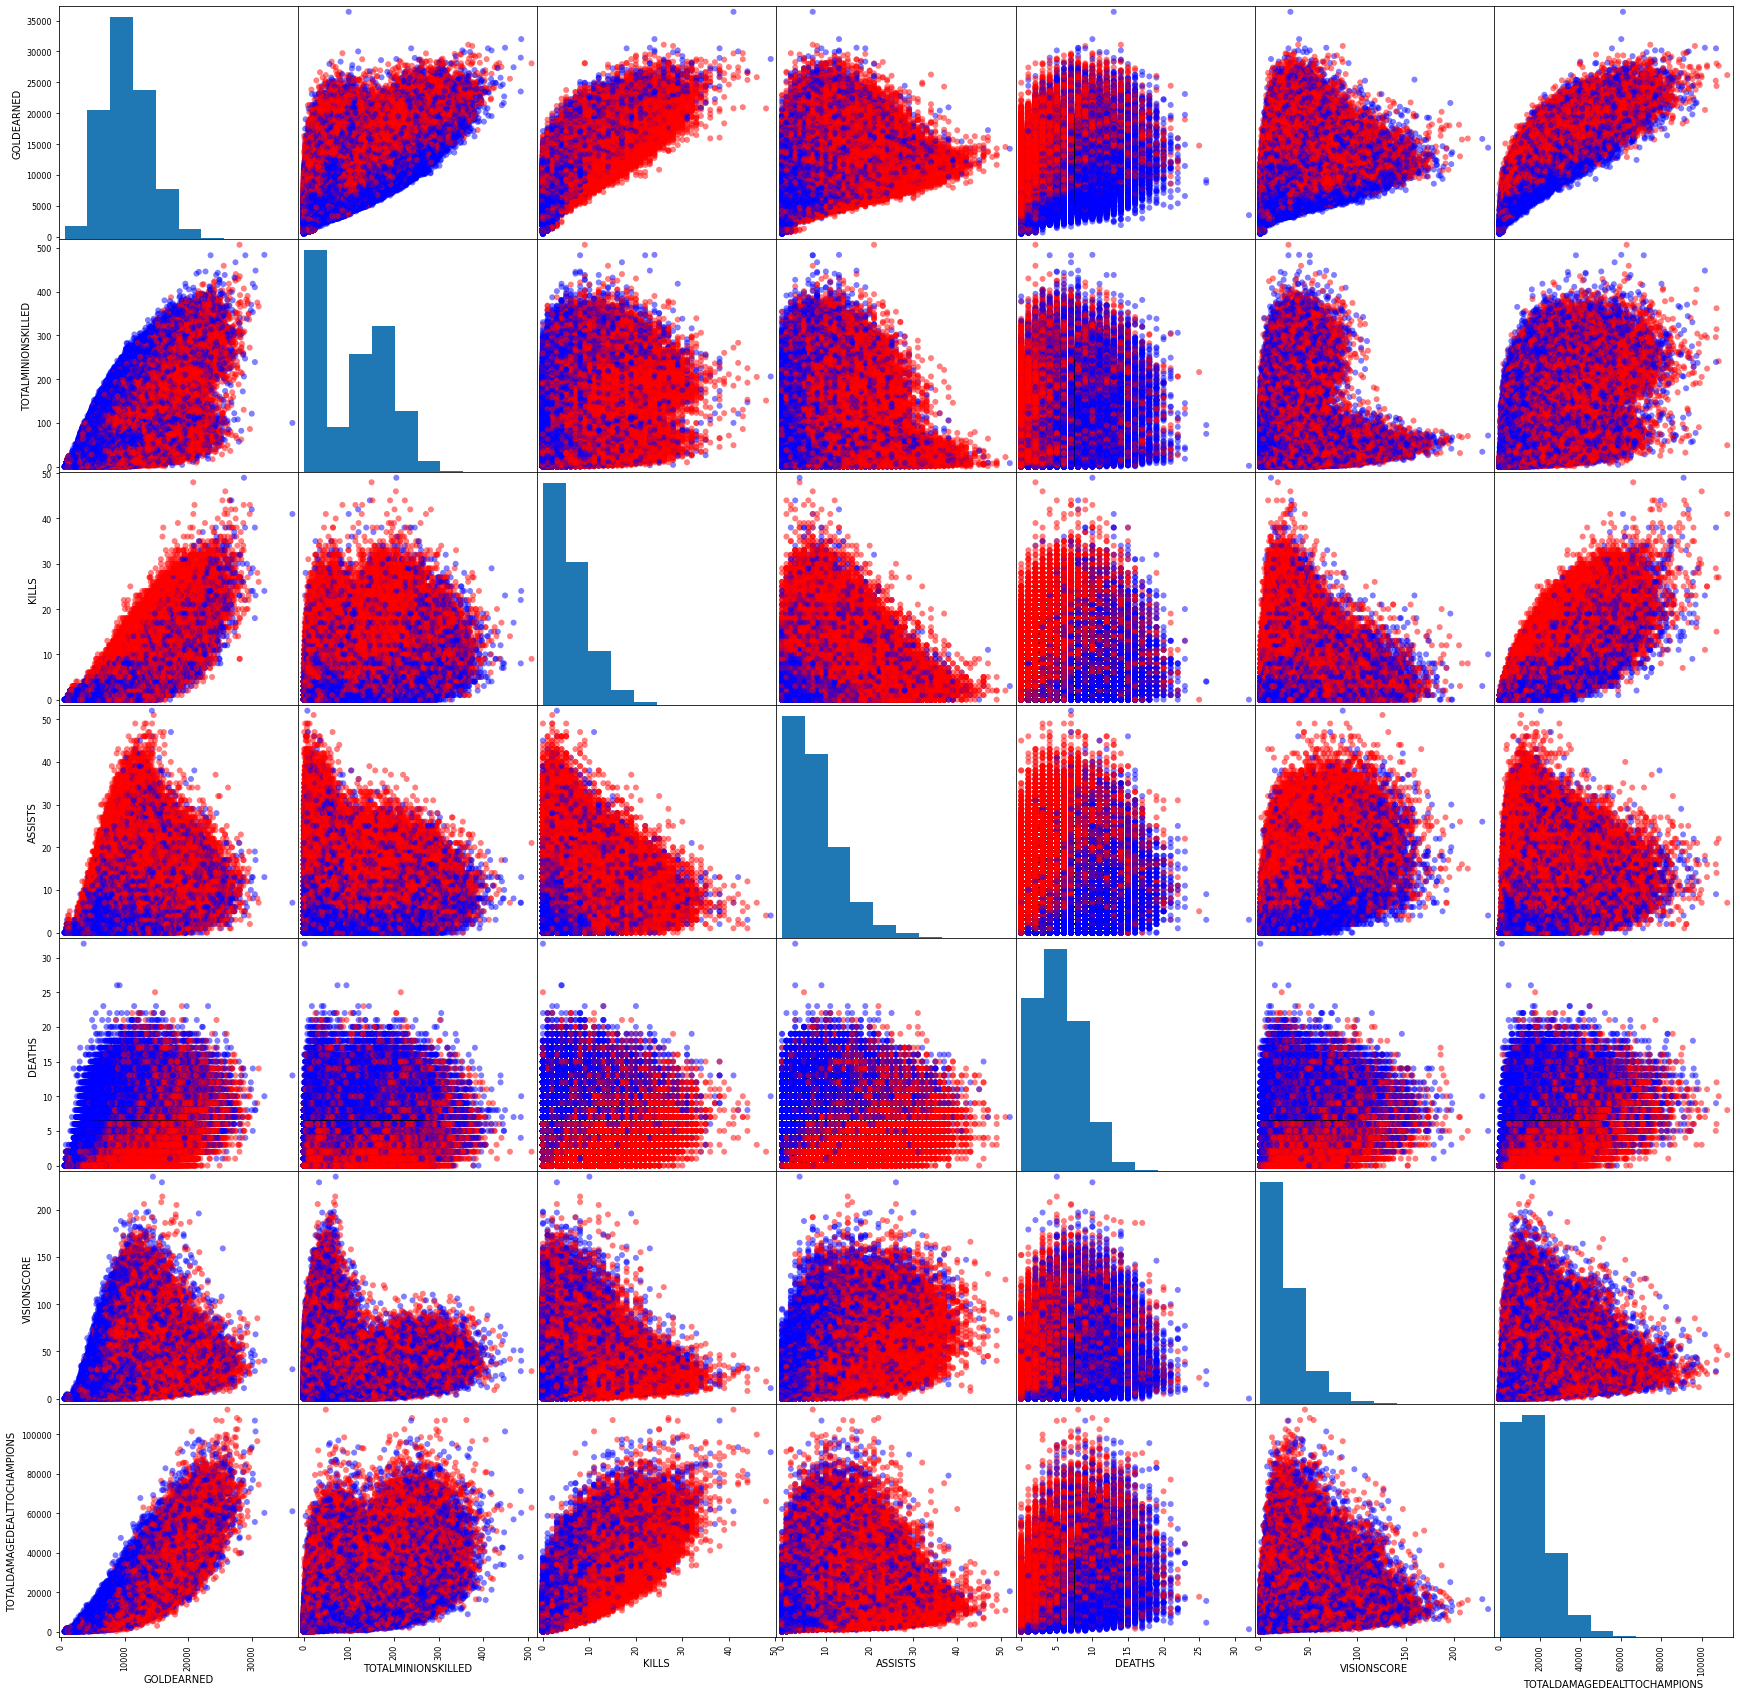

In [26]:
# Plotting a scatter matrix to understand the relationship between features
df_scatter = matches_merged
df_scatter['WIN']=df_scatter['WIN'].astype(int)
colors = {0:'blue', 1:'red'}
pd.plotting.scatter_matrix(df_scatter[['GOLDEARNED', 'TOTALMINIONSKILLED', 'KILLS', 'ASSISTS', 'DEATHS',
       'CHAMPION', 'VISIONSCORE', 'TOTALDAMAGEDEALTTOCHAMPIONS',
       'SUMMONERNAME', 'REGION', 'MATCH_ID', 'ROLE', 'PUUID', 'Rating']],figsize=(30,30),grid=True,
                           marker='o', c= df_scatter['WIN'].map(colors))


#### Inference
- It is evident from the scatter matrix that linear relationship exist between, 
    - Golds Earned vs Kills
    - Golds Earned vs Total Minions Killed
    - Golds Eanred vs Total Damage to Champions
    - Kills vs Total Damage to Champions

### Champion Statistics

Total unique champions

In [27]:
#finding the unique champions in the dataframe
champs = matches.CHAMPION.unique().tolist()
len(champs)

156

### Champion's Feature Averages

In [28]:
#grouping by champions to fund the average values for each champion 
matches.groupby(['CHAMPION']).mean()

,GOLDEARNED,TOTALMINIONSKILLED,WIN,KILLS,ASSISTS,DEATHS,VISIONSCORE,TOTALDAMAGEDEALTTOCHAMPIONS
CHAMPION,,,,,,,,
Aatrox,10349.436676,153.035368,0.508113,5.132835,5.642582,5.225050,17.342127,17413.096183
Ahri,10362.939693,157.324424,0.503007,5.521884,7.392249,4.870197,22.469262,17648.373204
Akali,10421.126103,152.142651,0.467329,7.028768,4.815597,5.554735,17.488544,18535.242532
Akshan,11485.754685,148.080282,0.442324,8.095926,5.888430,6.570053,19.164174,19451.137700
Alistar,7051.641102,30.994346,0.492444,1.644803,13.039272,5.702066,49.260306,6538.861725
...,...,...,...,...,...,...,...,...
Zed,11398.225872,157.906937,0.495238,8.039070,5.050469,5.747207,19.113686,20089.082415
Ziggs,11050.390338,178.327380,0.513842,4.915521,7.903108,5.137078,19.465708,21854.242722
Zilean,7938.739095,46.735991,0.527528,2.192942,12.743343,4.633393,48.075314,9263.117955


### Champion Win Rate

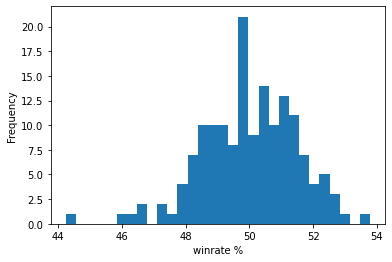

In [29]:
#Finding the winrate of champions
df_champ_main = matches.copy()
df_champ_main = pd.get_dummies(df_champ_main, columns=['WIN'])

df_champ = df_champ_main.groupby(['CHAMPION'])['WIN_True','WIN_False'].sum()
df_champ['win_percentage']=np.nan

for i in df_champ.index.unique(): 
    n = df_champ[df_champ.index==i]['WIN_True'] + df_champ[df_champ.index==i]['WIN_False']
    df_champ['win_percentage'].loc[(df_champ.index==i)]=(df_champ[df_champ.index==i]['WIN_True']/n)*100

plt.figure()
df_champ.win_percentage.plot.hist(bins = 30)
plt.xlabel("winrate %")
plt.show()

### Champion Win Rate by Role

In [30]:
#Grouping by role and champion and finding the number of wins and losses 
df_champ_role = df_champ_main.groupby(['ROLE','CHAMPION'],as_index=False)['WIN_True','WIN_False'].sum()
df_champ_role['win_percentage']= df_champ_role['WIN_True']/(df_champ_role['WIN_True']+df_champ_role['WIN_False'])*100

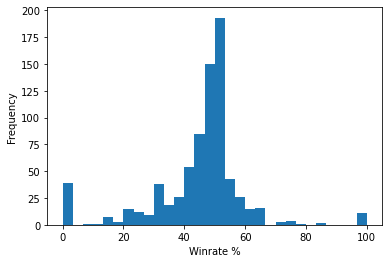

In [31]:
#Binning the win percentage of champion based on role 
plt.figure()
df_champ_role.win_percentage.plot.hist(bins = 30)
plt.xlabel("Winrate %")
plt.show()

#### Inference
- All champion win rates are within the range of 44 to 54 %
    - This is expected since the game is constantly balanced so that all champions have an amlost similar winrate
- Champion win rates by role have a range of 0 to 100 %
    - This implies some champions have higher win rates in certain roles

